# SLT-CE-5: Constant Shift Embedding

# Introduction

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

## Setup

We start by importing some possibly necessary python packages.

In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
import random
from mpl_toolkits.mplot3d import Axes3D
import igraph as ig
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [2]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [3]:
# initialize data matrix which will adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0],pair[1]] = 1
        DATA[pair[1],pair[0]] = 1

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [76]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data (already symmetric)
        n = PMAT.shape[0]
        S = PMAT
        
        #D = np.ones([n, n])- S
        
        
        D = np.zeros([n, n])
        
        for i in range(n):
            for j in range(n):
                D[i, j] = S[i, i]+ S[j, j]- 2* S[i, j]
        
        
        # Constant shift embedding ------------------------------------------
        # centralization
        e = np.ones([n, 1])
        Q = np.eye(n)- 1/n* np.dot(e, e.T)
        
        Sc = np.dot(Q, np.dot(S, Q))
        
        # diagonal shift
        w_Sc, _ = np.linalg.eigh(Sc)
        
        # making positive-semidefinite
        S_tilde = Sc - np.min(w_Sc)* np.eye(n)
        
        # off-diag shifted dissimilarities (squared distances)
        D_tilde = np.zeros([n, n])
        
        for i in range(n):
            for j in range(n):
                D_tilde[i, j] = S_tilde[i, i]+ S_tilde[j, j]- 2* S_tilde[i, j]
                
        self.D_tilde = D_tilde
                
        # Reconstruction -------------------------------------------------------
        # centralized dot product
        Sc_tilde = -1/2* np.dot(Q, np.dot(D_tilde, Q))
        
        self.Sc_tilde = Sc_tilde
        
        # loss-free reconstruction
        w_Sc_tilde, v_Sc_tilde = np.linalg.eigh(Sc_tilde)
        
        w_Sc_tilde = np.flip(w_Sc_tilde, axis = 0)
        v_Sc_tilde = np.flip(v_Sc_tilde, axis = 1)
        
        thresh = 1E-10
        w_Sc_tilde[np.asarray(np.where(w_Sc_tilde < thresh)).reshape(-1)] = 0
        #w_nonzeros = np.asarray(np.where(w_Sc_tilde > thresh)).reshape(-1)        

        #
        self.eigenvalues = w_Sc_tilde #[w_nonzeros]
        self.eigenvectors = v_Sc_tilde #[:, w_nonzeros]
        
    def plot_eigenspectrum(self, p = 0):
        
        plt.figure()
        plt.plot(self.eigenvalues)
        
        if p != 0:
            vl = self.eigenvalues[p]
            plt.hlines(vl, 0, len(self.eigenvalues), linestyle = '--')
            plt.vlines(p, 0, np.max(self.eigenvalues), linestyle = '--')
            
        plt.xlim((-2, 1000))
        plt.ylim((10, 70))
        plt.xlabel('eigenvalue index')
        plt.show()
        
        
        
    def get_embedded_vectors(self, p = 0):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        if p == 0:
            p = len(self.eigenvalues)
    
        self.Omega_p = np.diag(self.eigenvalues[:p])
        self.Vp = self.eigenvectors[:, :p]
        
        Xp = np.dot(self.Vp, np.sqrt(self.Omega_p))
        
        return Xp
    
    def predict_embedded_vectors(self, p, S_new):
        """Return predicted embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        if p == 0:
            p = len(self.eigenvalues)
            
        Sc_tilde = self.Sc_tilde
        n = Sc_tilde.shape[0]
        
        Sc_new = np.zeros([n, n])
        
        for i in range(n):
            for j in range(n):
                Sc_new[i, j] = S_new[i, j]- 1/n* np.sum(S_new[i, :])- 1/n* np.sum(Sc_tilde[:, j])+ 1/n**2* np.sum(Sc_tilde)
        
        Xp = np.dot(np.dot(Sc_new, self.Vp),  np.sqrt(np.linalg.inv(self.Omega_p)))
        
        return Xp
        
        

# Problems:

Solve all the problems to get 1 point. To get an additional point you need to solve the extension. 

_Note that the extension in this coding exercise will not be an independent task, but rather a valid proof that your results are aligned with the ground truth provided in [2]. Hence you will get an additional point if you can show that not only you are able to implement and visualize CSE algorithm, but also that you can actually make it work on a real-life data set._  

Note that above all, we will validate the working code. Make sure that your plots are readable and informative.

## Problem 0

Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm.

*Brief description of the model/algorithm:*

The idea of pairwise clustering is to minimize the sum of pairwise intra-cluster distances under the cost function <br>

$$ H^{pc} = \frac{1}{2} \sum_{\nu=1}^k \frac{\sum_{i=1}^n \sum_{j=1}^n M_{i \ \nu} \, M_{j \ \nu} \, D_{i \,j}}{\sum_{l=1}^n M_{l \ \nu}}$$

To solve this assignment problem is NP hard, but in the special case of squared Euclidean distances, the cost function $H^{pc}$ is identical to $H^{km}$, which can be solved efficiently. The paper introduces a method to transform the k-means problem such that it can be minimized to obtain the optimal clustering in the case of an arbitrary dissimilarity matrix $D$. The method exploits the invariance of the cost function under symmetrizing the dissimiliarity matrix under additive shifts of the off-diagonal element of the dissimilarity matrix.<br>

The constant-shift embedding process flow looks as follows: <br>
$ D \rightarrow \text{decomposition} \, D_{ij} = S_{ii}+ S_{jj}- 2 S_{ij} \rightarrow S$ i.e. the dissimilarity matrix is transformed into a similarity matrix <br>
$ S \rightarrow \text{centralization} \, S^c = QSQ \rightarrow  S^C = -\frac{1}{2} D^c$ the similarity matrix is centralized with $Q= I_n-\frac{1}{n}e_n e_n^T$ <br>
$ S^c \rightarrow \text{diagonal shift} \, \tilde{S}= S^c-\lambda_n(S^c) I_n \rightarrow \tilde{S}=X X^T $ the diagonal of $S^c$ is shifted by the smallest eigenvalue such that now all eigenvalues are $0 \leq \lambda_i$ <br>
$ \tilde{S} \rightarrow \text{off-diag. shifted dissimilarities} \rightarrow \tilde{D}_{ij}= \tilde{S}_{ii}+ \tilde{S}_{jj}- 2 \tilde{S}_{ij}$ a shift in the diagonal of $S^c$ leads to a off-diagonal shift of the dissimilarities <br>
$\tilde{D} \rightarrow \text{clustering} \rightarrow M(\tilde{D}) = M(D)$ clustering can be obtained for $\tilde{D}$ by means of kmeans which leads the same assignment as for the original problem <br>

The vector representation can be reconstructed by:
$\tilde{D} \rightarrow \text{decompostion} \tilde{D}_{ij}= S_{ii}^{new}+ \tilde{S}^c_{jj}- 2 S_{ij}^{new} \rightarrow S^{new}$ the similarity matrix can be constructed from the dissimilarity matrix by a decomposition <br>
$ S^{new} \rightarrow \text{centering} (S^{new})^c_{ij} = S_{ij}^{new}- \frac{1}{n} \sum_{k=1}^n S_{ik}^{new}- \frac{1}{n}  \sum_{k=1}^n \tilde{S}_{kj}^c + \frac{1}{n^2}  \sum_{k,l=1}^n \tilde{S}_{kl}^c \rightarrow (S^{new})^c$ the similarity matrix is centered <br>
$ (S^{new})^c \rightarrow X_p^{new} = (S^{new})^c V_p \Lambda^{-1/2}$ which follows from the eigenvalue decomposition and is basically a projection of the new objects onto the eigenvectors of $\tilde{S}^c$  <br>
$\hat{\nu}(x_p^{new})_i= \text{argmin}_\nu ||(x_p^{new})_i- y_\nu||^2$ Finally, the objects can be assigned to the closest centroid


## Problem 1

Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.

In [77]:
CSE = ConstantShiftEmbedding()

Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].

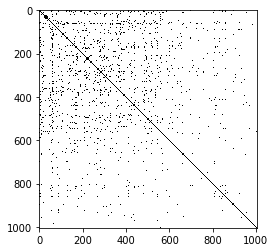

In [78]:
CSE.fit(DATA)

plt.figure()
plt.imshow(DATA, cmap= 'binary')
plt.show()

## Problem 2

Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.

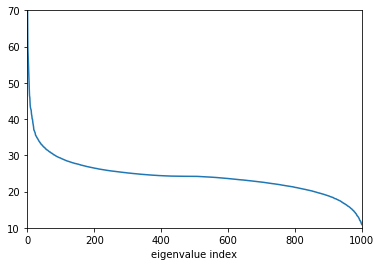

In [45]:
## Compute eigen-spectrum
CSE.plot_eigenspectrum()

In [97]:
## Determine a good cut-off value
p_opt = 100 ## change accordingly
print("Chosen cut-off value is: ",p_opt)

Chosen cut-off value is:  100


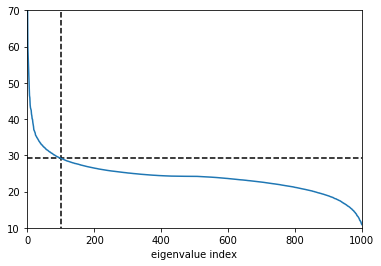

In [98]:
## Plot spectrum and indicate the cut-off value on the spectrum
CSE.plot_eigenspectrum(p_opt)

Looking at the curve of eigenvalues, a rapid decrease in the beginning is followed by a large range over which the eigenvalues barely change. <br>
Therefore, p_opt has been chosen to capture the initial rapid decrease up to the point, where the curve "levels off".

In [ ]:
##see the feedback on piazza about this issue

## Problem 3

Perform K-MEANS algorithm on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. Plot the distance matrices for varying number of clusters K, both for the denoised ($p = p^*$ - from the previous step) and the original version as shown in figure 5 in [1]. To make the plots meaningful, sort the nodes according to the cluster belongings (see the figure). For now, there is no need to include the actual ground truth labels given in [2].

C:\Users\engel\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'c'
  s)
C:\Users\engel\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


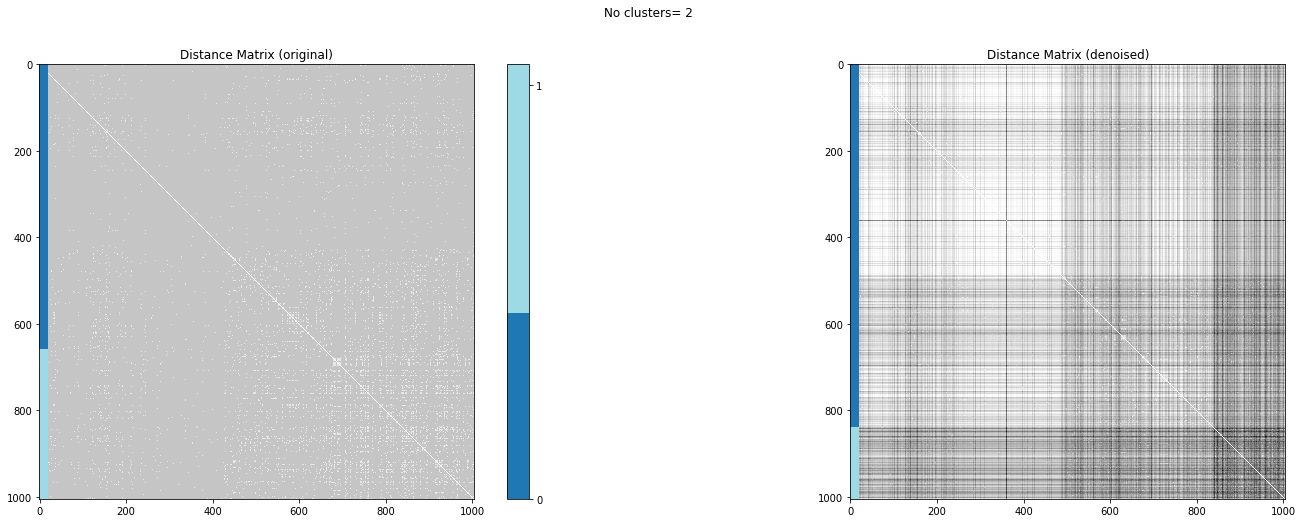

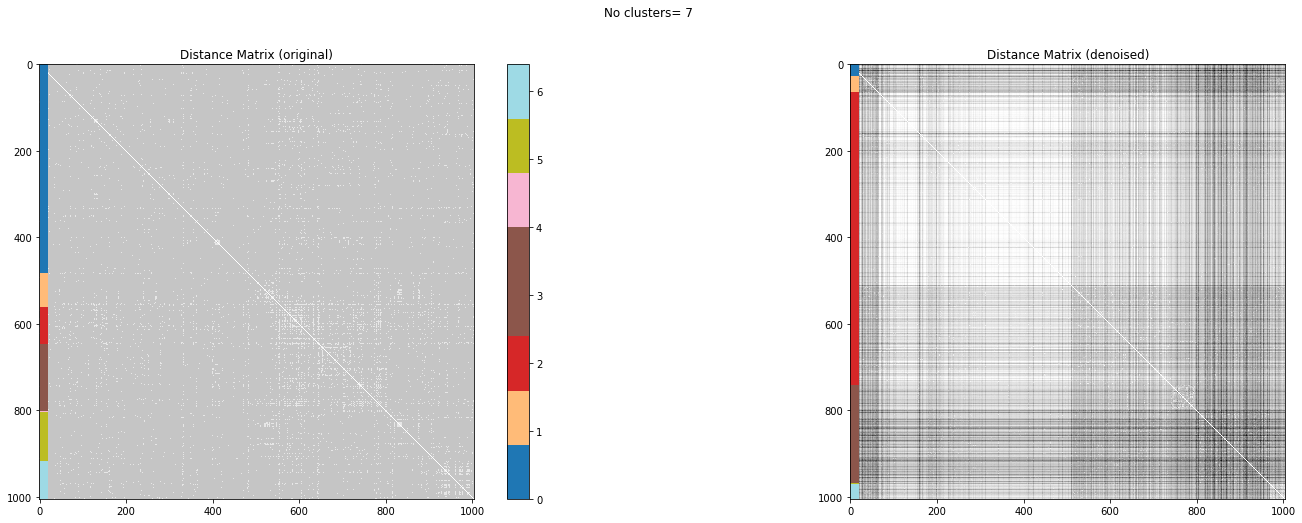

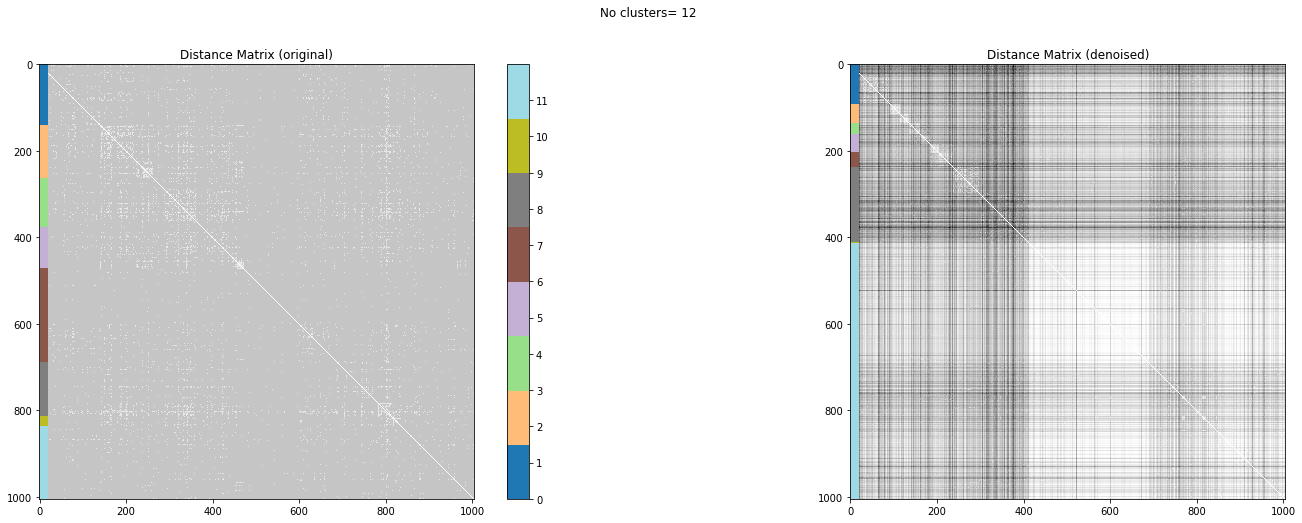

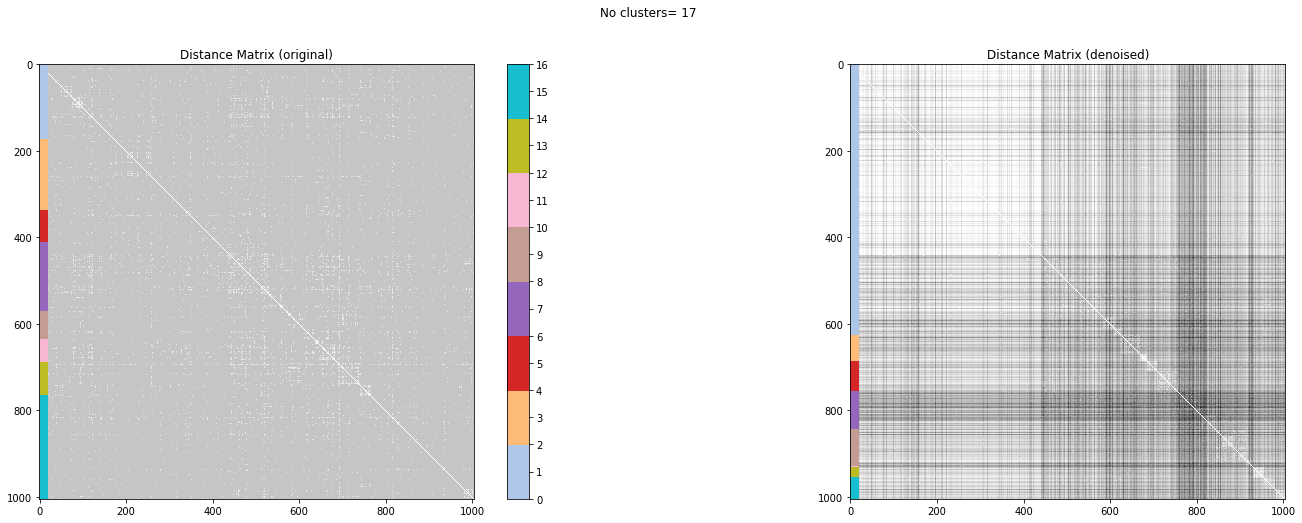

In [114]:
## Distance matrices
#-------------------------------------------------------------------
# embedding [n_samples, n_features] i.e. {xi}_0^n in p-dimensional space
Xp_orig = CSE.get_embedded_vectors()

# dissimilarity matrix
Dp_orig = -2* np.dot(Xp_orig, Xp_orig.T)

#-------------------------------------------------------------------
# embedding
Xp_denoised = CSE.get_embedded_vectors(p_opt)

# dissimilarity matrix
Dp_denoised = -2* np.dot(Xp_denoised, Xp_denoised.T)


for nc in [2, 7, 12, 17]:
    cm = plt.get_cmap('tab20', nc)
    
    #----------------------------original----------------------------------
    # kmeans 
    kmeans_orig = KMeans(n_clusters = nc, init='k-means++', random_state = 42)
    kmeans_orig.fit(Xp_orig)
    c_indices_o = np.argsort(kmeans_orig.labels_)

    # distance matrix
    Xp_orig_dist = squareform(pdist(Xp_orig, metric='sqeuclidean' ))
    # Xp_orig_dist = -2* np.dot(Xp_orig, Xp_orig.T)

    dist_orig = Xp_orig_dist[c_indices_o][:, c_indices_o]
    
    #dd = np.arange(len(dist_orig))
    #dist_orig[dd, dd] = 0

    #------------------------------denoised---------------------------------
    # kmeans
    kmeans_denoised = KMeans(n_clusters = nc, init='k-means++', random_state = 42)
    kmeans_denoised.fit(Xp_denoised)
    c_indices_d = np.argsort(kmeans_denoised.labels_)

    # distance matrix
    Xp_denoised_dist = squareform(pdist(Xp_denoised, metric='sqeuclidean' ))
    #Xp_denoised_dist= -2* np.dot(Xp_denoised, Xp_denoised.T)

    dist_denoised = Xp_denoised_dist[c_indices_d][:, c_indices_d]
    
    #dist_denoised[dd, dd] = 0
    
    #---------------------------------------------------------------------
    # coloring according to cluster assignment
    xmap, ymap = np.meshgrid(np.arange(20), np.arange(0, Xp_orig.shape[0]))
    
    left_orig = np.dot(kmeans_orig.labels_[c_indices_o].reshape(-1, 1), np.ones([1, 20]))
    left_denoised = np.dot(kmeans_denoised.labels_[c_indices_d].reshape(-1, 1), np.ones([1, 20]))
    
    #---------------------------------------------------------------------
    # plot dissimilarity matrix
    fig, ax = plt.subplots(1, 2, figsize=(26, 8))
    fig.suptitle('No clusters= '+ str(nc))

    # plot distance matrix (embedding, kmeans applied)
    ax[0].imshow(dist_orig, cmap = 'binary', vmin=45, vmax=60)
    im = ax[0].contourf(xmap, ymap, left_orig, c= kmeans_orig.labels_[c_indices_o], cmap = cm)
    ax[0].set_title('Distance Matrix (original)')
    fig.colorbar(im, ax= ax[0], ticks=range(nc))
    
    # plot distance matrix (embedding, kmeans applied)
    ax[1].imshow(dist_denoised, cmap = 'binary')#, vmin=0, vmax=3)
    ax[1].contourf(xmap, ymap, left_denoised, c= kmeans_denoised.labels_[c_indices_d], cmap = cm)
    ax[1].set_title('Distance Matrix (denoised)')

    fig.show()


Observation: Kmeans is not unique in terms of ordering of the cluster assignments, therefore the distance matrices are ordered differently.This could be overcome by deriving the mapping between the two solutions and taking it into account when sorting. <br>

Observation 2: Different nodes are sometimes assigned to different clusters for the denoised case compared to the original (i.e. not denoised) case. This becomes obvious by the color bars which have different lengths, when "color-corrected" by eye. Compare e.g. the two plots for No clusters= 14: For the denoised distance matrix, the pink cluster seems to be quite large. However, for the original distance matrix, no cluster (ignoring color) of the same size can be found. <br>

Ignore the colormap, something seems not to work


In [ ]:
##it would have been better to show the denoised similarity matrix or just invert the color of the imshow,
##since this way the block diagonal form of the matrix is form by white blocks, not very recognizable.

## Problem 4

Now calculate the embeddings for p = 2, 3 and plot clusterings for a few values of K. Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Alternatively, you could use $p^*$ and then apply a dimensionality reduction technique to move to 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.

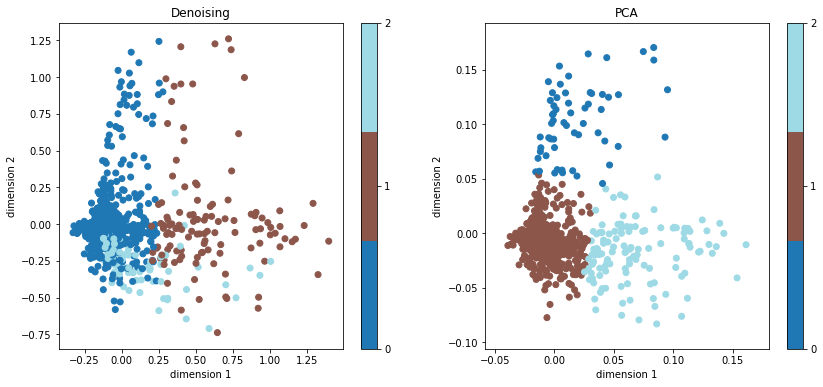

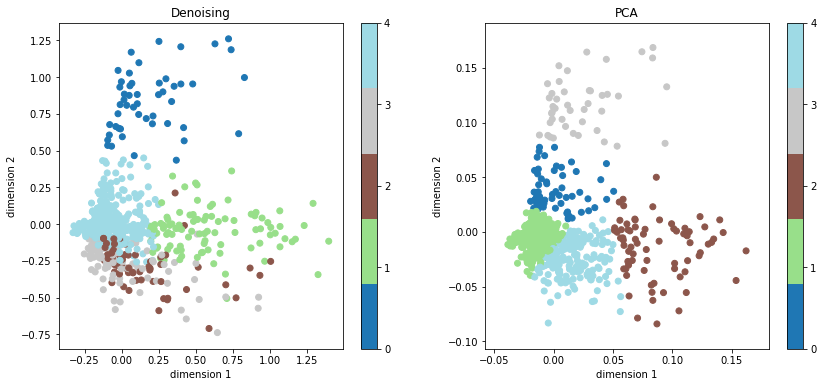

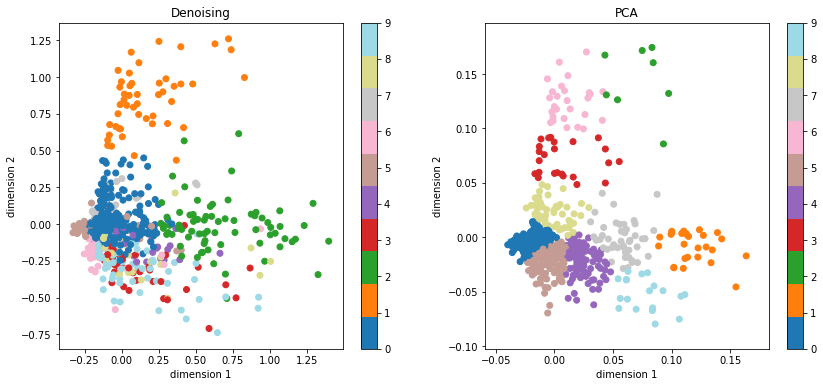

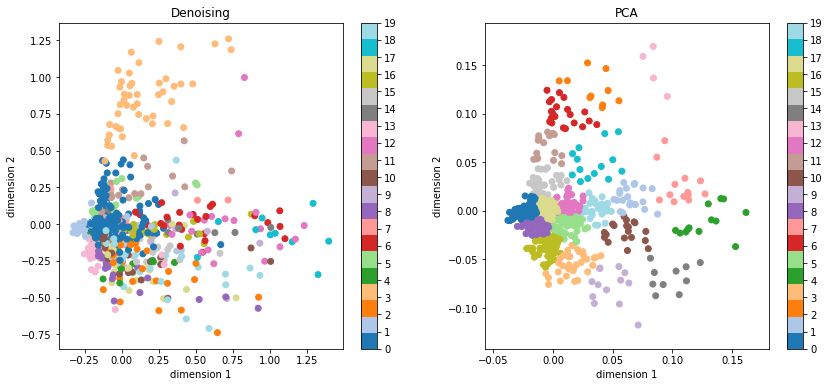

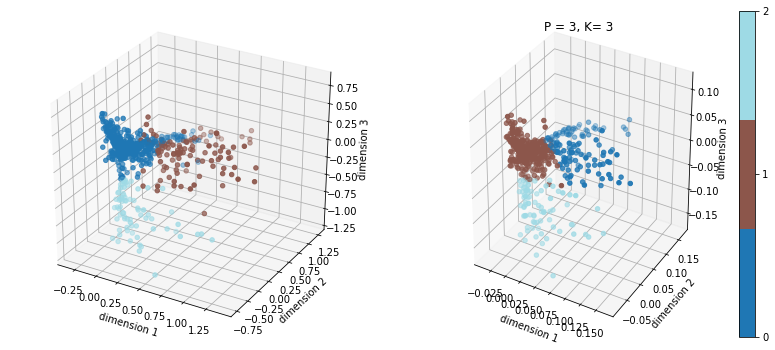

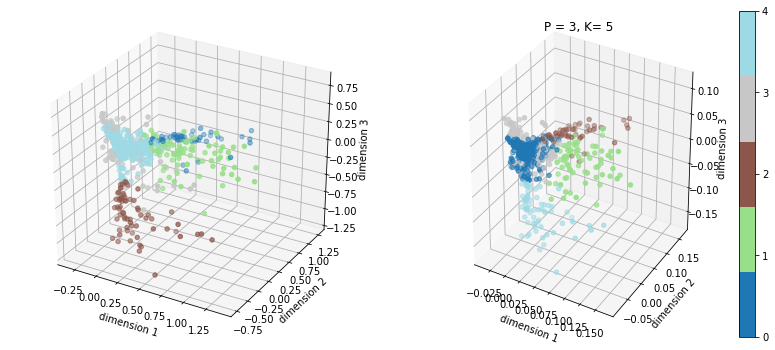

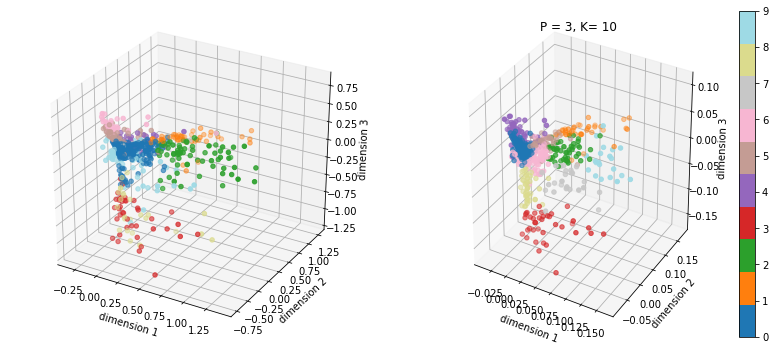

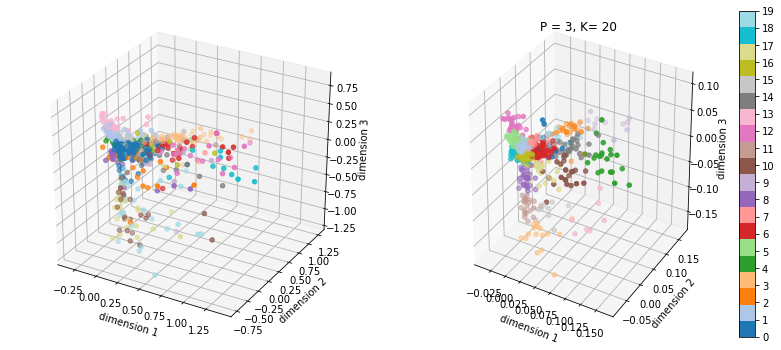

In [157]:

Xp = CSE.get_embedded_vectors(p_opt)
pca_kp = PCA(n_components= 2)
pca_kp.fit(Xp.T)

embeddings = pca_kp.components_

kmeans_kp = KMeans(n_clusters = 5, init='k-means++', random_state = 42).fit(embeddings.T)


## Get embeddings, run K-MEANS and generate plots
for p in [2, 3]:
    for k in [3, 5, 10, 20]:
        cm = plt.get_cmap('tab20', k)
        
        # dimensionality reduction via denoising
        Xp = CSE.get_embedded_vectors(k)     
        kmeans_kp = KMeans(n_clusters = k, init='k-means++', random_state = 42).fit(Xp)
        
        # dimensionality reduction via PCA
        Xp = CSE.get_embedded_vectors(p_opt)
        pca_kp = PCA(n_components= p)
        pca_kp.fit(Xp.T)
        
        embeddings = pca_kp.components_
        kmeans_pca = KMeans(n_clusters = k, init='k-means++', random_state = 42).fit(embeddings.T)
        
        
        if p ==2:
            fig, ax = plt.subplots(1, 2, figsize=(14, 6))
            plt.title('P = '+ str(p)+ ', K= '+ str(k))
            
            ax[0].set_title('Denoising')
            im = ax[0].scatter(Xp[:, 0], Xp[:, 1], c= kmeans_kp.labels_, cmap = cm)
            ax[0].set_xlabel('dimension 1')
            ax[0].set_ylabel('dimension 2')
            fig.colorbar(im, ax= ax[0], ticks=range(k))
            #ax[0].clim(-0.5, k-0.5)

            ax[1].set_title('PCA')
            im = ax[1].scatter(embeddings[0, :], embeddings[1, :], c= kmeans_pca.labels_, cmap = cm)
            ax[1].set_xlabel('dimension 1')
            ax[1].set_ylabel('dimension 2')
            fig.colorbar(im, ax= ax[1], ticks=range(k))
            #ax[1].clim(-0.5, 5-0.5);
            
            plt.show()
            
            
        else:
            fig = plt.figure(figsize = (14, 6))
            #plt.title('P = '+ str(p)+ ', K= '+ str(k))
            ax = fig.add_subplot(121, projection='3d')
            #ax.text2D(0.05, 0.95, 'P = '+ str(p)+ ', K= '+ str(k), transform=ax.transAxes)
            ax.scatter(Xp[:, 0], Xp[:, 1], Xp[:, 2], c= kmeans_kp.labels_, cmap = cm)
            ax.set_xlabel('dimension 1')
            ax.set_ylabel('dimension 2')
            ax.set_zlabel('dimension 3')
            
            ax = fig.add_subplot(122, projection='3d')
            #ax.text2D(0.05, 0.95, 'P = '+ str(p)+ ', K= '+ str(k), transform=ax.transAxes)
            pl = ax.scatter(embeddings[0, :], embeddings[1, :], embeddings[2, :], c= kmeans_pca.labels_, cmap = cm)
            ax.set_xlabel('dimension 1')
            ax.set_ylabel('dimension 2')
            ax.set_zlabel('dimension 3')
            
            fig.colorbar(pl, ticks=range(k))
            plt.title("P = "+ str(p)+ ", K= "+ str(k))
            plt.show()

        

There seemed to be a problem with the titles of the 3D plots, which should read: <br>
P= 2, K= 3 <br>
P= 2, K= 5 <br>
P= 2, K= 10 <br>
P= 2, K= 20 <br>

The embedding by PCA leads to a clearer seperation between the different clusters.

## Problem 5 [optional]

Try the graph plot tools provided by python library [igraph](http://igraph.org/python/) to visualize the network and clusters.

*Hint:* Python igraph is a very nice and efficient graph library (see references). We recommend to check it
out. Especially, you can also plot networks with it and color the clusters.

In [17]:
## Your igraph visualization

## Remarks on the computational issues

_Insert here:_

## Extension

Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2].

To that end, solve at least one of the two following tasks to get an extra point:

1. Find a principled way to discover the true number of clusters, and show that your systematic search can recover the true number of clusters (which is 42 according to [2]) . You may consider using some stability measures mentioned and referenced in [1] or you may browse the literature to find something you like more to perform the model selection. As an example see figure 4 (b) in [1].
2. Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?

In [33]:
from scipy.optimize import linear_sum_assignment

def permute_prediction(C_pred, C_true):
    """ Permute labels in predicted labels such that they denote the same clusters as in L_true

    Args:
        C_pred (np.ndarray): Predicted clusters shape (N,)
        C_true (np.ndarray): True clusters shape (N,)

    Returns:
        C_permuted (np.ndarray): Permuted clusters
    """
    n_clusters = int(np.max(C_true) + 1)
    
    # 
    I = np.eye(n_clusters,dtype='int')
    MP = I[C_pred]
    MT = I[C_true]
    
    # MO(i,j) is the cost of assigning cluster i in L_pred to cluster j in L_true
    MO = - MP.T @ MT

    # find best permutation using the hungarian algorithm
    # ie permute rows in MP to have minimum trace of MP.T @ MT.
    row_ind, col_ind = linear_sum_assignment(MO)
    
    P = np.zeros((n_clusters,n_clusters),dtype='int')
    P[col_ind, row_ind] = 1
                 
    #MO = - P @ MP.T @ MT
    
    # 
    C_permuted = np.argmax(P @ MP.T, axis=0)
    
    return np.reshape(C_permuted, C_pred.shape), P 


In [106]:
# Initialize community members affiliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

AFFILIATIONS = np.int8(AFFILIATIONS)

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

n = DATA.shape[0]

# number of clusters considered
no_cluster = [5, 10, 20, 30, 40, 42, 45, 50, 60]

# report stability
stability = np.zeros([len(no_cluster), 10])

# repeat data splitting (for error bars) -----------------------------------------------
for s in range(10):
    # Data split
    complete_idx = np.arange(0, n)
    train_idx = random.sample(range(n), int(n/2))
    test_idx = np.setdiff1d(complete_idx, train_idx)[: -1]
    
    # ------------------------set1----------------------------
    set1_train = np.zeros([len(train_idx), len(train_idx)])
    set1_test = np.zeros([len(test_idx), len(train_idx)])
    
    for i, idxi in enumerate(train_idx):
        for j, idxj in enumerate(train_idx):
            set1_train[i, j] = DATA[idxi, idxj]

    # S_new: similarities between m new objects (rows) and n original objects (columns) 
    for i, idxi in enumerate(test_idx):
        for j, idxj in enumerate(train_idx):
            set1_test[i, j] = DATA[idxi, idxj]   
    
    # -----------------------set2----------------------------
    set2_train = np.zeros([len(test_idx), len(test_idx)])
    set2_test = np.zeros([len(train_idx), len(test_idx)])
    
    for i, idxi in enumerate(test_idx):
        for j, idxj in enumerate(test_idx):
            set2_train[i, j] = DATA[idxi, idxj]
    
    # S_new: similarities between m new objects (rows) and n original objects (columns) 
    for i, idxi in enumerate(train_idx):
        for j, idxj in enumerate(test_idx):
            set2_test[i, j] = DATA[idxi, idxj]   
           
    # -----------------------set1----------------------------
    N_test1 = set1_test.shape[0]

    # calculating assignment on training data
    CSE_set1 = ConstantShiftEmbedding()
    CSE_set1.fit(set1_train)
    
    Xp_set1_train = CSE_set1.get_embedded_vectors(p_opt)

    # predicting for testing data
    Xp_set1_test = CSE_set1.predict_embedded_vectors(p_opt, set1_test)
    
    # -----------------------set2----------------------------
    N_test2 = set2_test.shape[0]

    # calculating assignment on training data
    CSE_set2 = ConstantShiftEmbedding()
    CSE_set2.fit(set2_train)
    
    Xp_set2_train = CSE_set2.get_embedded_vectors(p_opt)

    # predicting for testing data
    Xp_set2_test = CSE_set2.predict_embedded_vectors(p_opt, set2_test)
    
    
    # loop over no of clusters -------------------------------------------------
    for i, k in enumerate(no_cluster):
        
        # -----------------------set1----------------------------
        # kmeans on training data of set 1
        kmeans_set1 = KMeans(n_clusters = k, init='k-means++', random_state = 42)
        kmeans_set1.fit(Xp_set1_train)
        set1_train_labels = kmeans_set1.labels_
        
        # kmeans on test set
        set1_test_labels = kmeans_set1.predict(Xp_set1_test)
        
        # -----------------------set2----------------------------
        # kmeans on training data of set 2
        kmeans_set2 = KMeans(n_clusters = k, init='k-means++', random_state = 42)
        kmeans_set2.fit(Xp_set2_train)
        set2_train_labels = kmeans_set2.labels_
        
        # kmeans on test set
        set2_test_labels = kmeans_set2.predict(Xp_set2_test)
        
        # --------------------------------------------------------
        # mapping predicted clusters <-> true clusters (training set)        
        set1_train_perm_labels, P = permute_prediction(set1_train_labels, set2_train_labels)      
        
        # apply mapping
        I = np.eye(k, dtype='int')
        MP = I[set1_test_labels]
        
        set1_test_perm_labels = np.reshape(np.argmax(P @ MP.T, axis=0), set1_test_labels.shape)
        
        # difference between label assignment -> 0 for coinciding labels
        # set1 train set <-> set2 test set
        # set1 test set <-> set2 train set
        wrong_labels_set1 = set1_train_perm_labels - set2_test_labels
        wrong_labels_set2 = set1_test_perm_labels - set2_train_labels
                
        stability[i, s] = 1/N_test1* (N_test1- np.count_nonzero(wrong_labels_set1)- np.count_nonzero(wrong_labels_set2))    

The true number of clusters (departments) is:  42


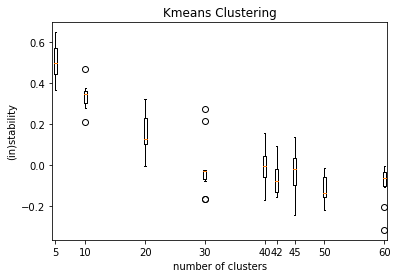

In [107]:
plt.figure()
plt.boxplot(stability.T, positions= np.asarray(no_cluster))
plt.xlabel('number of clusters')
plt.ylabel('(in)stability')
plt.title('Kmeans Clustering')
plt.show()

In [ ]:
##to have a definite answer you could hve compute what is the actual minimum and with what p value (since you have standard deviations).

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!